In [1]:
import os
import matplotlib.pyplot as plt
from scipy.interpolate import interp2d
import pandas as pd
from astropy.io import fits
from astropy.wcs import WCS
from astropy.nddata.utils import NoOverlapError
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.nddata.utils import Cutout2D
import montage_wrapper

In [2]:
gain_table = pd.DataFrame(
    [
        [1.62, 3.32, 4.71, 5.165, 4.745],
        [np.nan, 3.855, 4.6, 6.565, 5.155],
        [1.59, 3.845, 4.72, 4.86, 4.885],
        [1.6, 3.995, 4.76, 4.885, 4.775],
        [1.47, 4.05, 4.725, 4.64, 3.48],
        [2.17, 4.035, 4.895, 4.76, 4.69],
    ], 
    index=pd.Series(np.arange(6) + 1, name='camcol'), 
    columns=list('ugriz')
)
darkvar_r = pd.Series(
    [1.8225, 1.00, 1.3225, 1.3225, 0.81, 0.9025],
    name='darkvar_r'
)

In [3]:
s = '175.18885803222656+25.100849151611328'

In [4]:
elecs = pd.Series([], name='electron_images')
errs = pd.Series([], name='errors')
for i, frame in enumerate(os.listdir(os.path.join('montageGroups', s))):
    f = fits.open(os.path.join('montageGroups', s, frame))
    img = f[0]
    ff = f[1]
    sky = f[2]
    allsky, xinterp, yinterp = sky.data[0]
    sky_img = interp2d(
        np.arange(allsky.shape[1]),
        np.arange(allsky.shape[0]),
        allsky,
    )(xinterp, yinterp)
    calib_img = np.tile(np.expand_dims(ff.data, 1), img.data.shape[0]).T
    dn = img.data /calib_img + sky_img
    gain = gain_table.loc[img.header['camcol']][img.header['FILTER']]
    darkvar = darkvar_r.loc[img.header['camcol']]
    dn_err = np.sqrt(dn / gain + darkvar)
    img_err = dn_err * calib_img
    errs.loc[i] = img_err
    elecs.loc[i] = dn*gain

In [5]:
centre_pos = SkyCoord(
    175.18885803222656, 25.100849151611328,
    unit=u.degree, frame='icrs'
)
dx = 50 * u.arcsec
dy = 50 * u.arcsec

In [6]:
def get_cutout(data, wcs):
    cutout = Cutout2D(
        data,
        centre_pos,
        (dx, dy),
        wcs=wcs,
        mode='partial'
    )
    return cutout.data

def get_image_cutout(f):
    return get_cutout(f[0].data, WCS(f[0]))

In [7]:
# fitting_metadata = pd.read_pickle('../gzbuilder_results/lib/fitting_metadata.pkl')

In [8]:
# fitting_metadata.head()

In [9]:
def get_sigma_image(f):
    img = f[0]
    ff = f[1]
    sky = f[2]
    allsky, xinterp, yinterp = sky.data[0]
    sky_img = interp2d(
        np.arange(allsky.shape[1]),
        np.arange(allsky.shape[0]),
        allsky,
    )(xinterp, yinterp)
    calib_img = np.tile(np.expand_dims(ff.data, 1), img.data.shape[0]).T
    dn = img.data /calib_img + sky_img
    gain = gain_table.loc[img.header['camcol']][img.header['FILTER']]
    darkvar = darkvar_r.loc[img.header['camcol']]
    dn_err = np.sqrt(dn / gain + darkvar)
    img_err = dn_err * calib_img
    return img_err

def get_sigma_cutout(f):
    sigma_image = get_sigma_image(f)
    return get_cutout(sigma_image, WCS(f[0]))

In [10]:
cutouts = []
for i, frame in enumerate(os.listdir(os.path.join('montageGroups', s))):
    f = fits.open(os.path.join('montageGroups', s, frame))
    try:
        cutouts.append(get_image_cutout(f))
    except NoOverlapError:
        pass

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


In [11]:
good_cutout_mask = [np.all(np.isfinite(a)) for a in cutouts]
good_cutout_mask

[False, True]

In [12]:
sigma_cutouts = []
for i, frame in enumerate(os.listdir(os.path.join('montageGroups', s))):
    f = fits.open(os.path.join('montageGroups', s, frame))
    try:
        sigma_cutouts.append(get_sigma_cutout(f))
    except NoOverlapError:
        pass

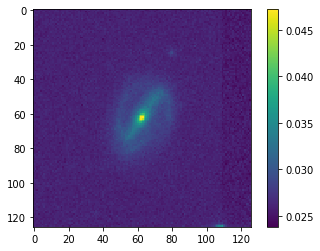

In [13]:
s1ps2 = np.nansum((sigma_cutouts[0]**2, sigma_cutouts[1]**2), axis=0)
n_vals = np.isfinite(sigma_cutouts[0]).astype(int) + np.isfinite(sigma_cutouts[1]).astype(int)
plt.imshow(np.sqrt(s1ps2 / n_vals))
plt.colorbar()

Say $x = \bar{x} + \sigma_x,\; y = \bar{y} + \sigma_y$

let $z=(x+y)/2$, then $\bar{z} = \frac{\bar{x} + \bar{y}}{2}$ and 
$$\sigma_z^2 = \frac{1}{2}(\sigma_x^2 + \sigma_y^2)$$
$$\sigma_z = \frac{1}{\sqrt{2}}\sqrt{\sigma_x^2 + \sigma_y^2}$$

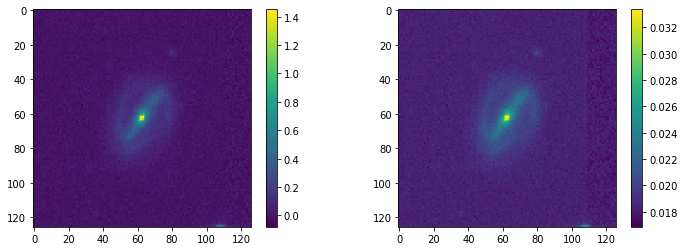

In [16]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.imshow(np.nanmean(cutouts, axis=0))
plt.colorbar()
plt.subplot(122)
si = np.sqrt(np.nanmean(np.array(sigma_cutouts)**2, axis=0))
plt.imshow(si)
plt.colorbar()

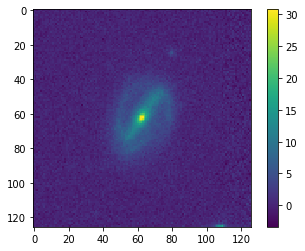

In [15]:
plt.imshow(np.nanmean(cutouts, axis=0) / si)
plt.colorbar()